In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Cosas que pueden observarse en info():

1.   Existen valores nulos en "Income"
2.   La fecha **Dt_customer** de cuando se metio al cliente en el Dataset no esta parseada



En primer lugar, vamos a proceder a eliminar los datos con valores a null en el campo "Income". El hecho de que no los sustituya por el valor medio del campo se debe a que un valor medio no sería un valor "real" para este dataset.

In [6]:
df = df.dropna()
df.shape

(2216, 29)

En segundo lugar creamos la columna **Customer_For** que indican los dias que lleva el cliente registrado en la base de datos.

In [7]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
most_recent_date = df['Dt_Customer'].max()
df['Customer_For'] = df.apply(lambda x: (most_recent_date - x['Dt_Customer']).days, axis=1)
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

Una vez termiando los cambios anterior, el siguiente paso será extraer nuevos atributos a partir de los atributos que existen ya en el Dataset. Las características que vamos a extraer son:

*   Edad del cliente a partir de su año de nacimiento
*   La cantidad que ha gastado el cliente en los diferentes productos
*   Crear un atributo numérico de 0/1 que indique si el cliente vive con alguna pareja
*   Crear un atributo que indique el número de hij@s que tenga el cliente
*   Indicar el tamaño de la unidad familiar del cliente
*   Simplificar los estudios del cliente
*   Eliminar atributos redundantes


In [8]:
# Edad del cliente
df['Age'] = 2021 - df['Year_Birth']

# Gasto total del cliente
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Vive con una pareja
df['Couple'] = df.apply(lambda x: 1 if (x['Marital_Status'] == 'Married' or
                                        x['Marital_Status'] == 'Together') 
                                        else 0, axis=1)

# Numero de hijos que tenga el cliente
df['Childrens'] = df['Kidhome'] + df['Teenhome']

# Tamaño de la unidad familiar
df['Family_Size'] = df['Couple'] + 1 + df['Childrens']

# Simplificamos la informacion de los estudios
df["Education"] = df["Education"].replace({"Basic":"Undergraduate",
                                             "2n Cycle":"Undergraduate", 
                                             "Graduation":"Graduate", 
                                             "Master":"Postgraduate", 
                                             "PhD":"Postgraduate"})

# Eliminamos atributos que nos son relevantes
to_delete = ['Year_Birth', 'Dt_Customer', 'Marital_Status', 'Z_CostContact',
             'Z_Revenue', 'ID']
df = df.drop(columns=to_delete)

Una vez calculado los nuevos atributos vamos a ver las estadisticas del dataset

In [9]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Couple,Childrens,Family_Size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,512.006318,52.179603,607.075361,0.645307,0.947202,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,232.469034,11.985554,602.900476,0.478528,0.749062,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,340.000000,44.000000,69.000000,0.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,513.000000,51.000000,396.500000,1.000000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,686.000000,62.000000,1048.000000,1.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1063.000000,128.000000,2525.000000,1.000000,3.000000,5.000000


El siguiente paso que vamos a realizar será detectar los posibles outlines que puede haber en alguno de los atributos.

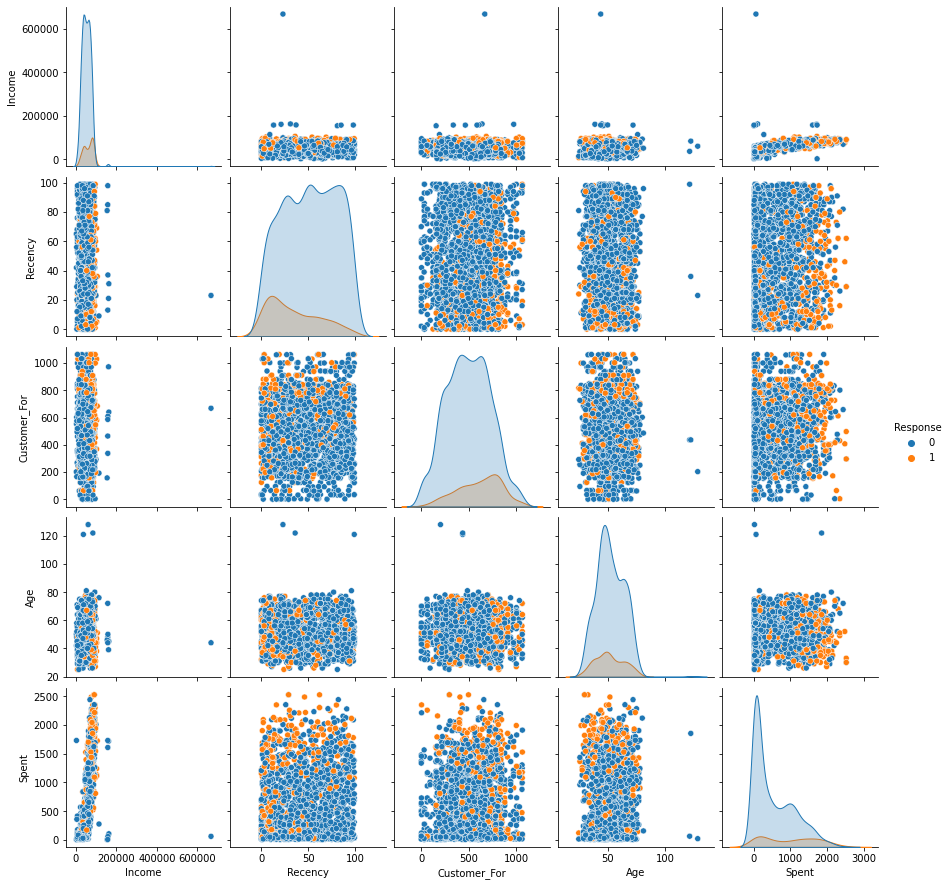

In [10]:
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Response"]
sns.pairplot(df[to_plot], hue="Response")

Hemos elegido los atributos del dataset que son numéricos y cuyos valores máximos y mínimos se encontraran fuera de los cuartiles. Como se puede observar en las gráficas de arriba, los atributos que presentan outliners son **Age** e **Income**. A continuación eliminaremos estos outliners del dataset.

In [11]:
df.drop(df[df.Age > 95].index, inplace=True)
df.drop(df[df.Income > 200000].index, inplace=True)
df.shape

(2212, 29)

A continuación vamos a observar la matriz de correlación y eliminar atributos que se encuentren correlacionados.

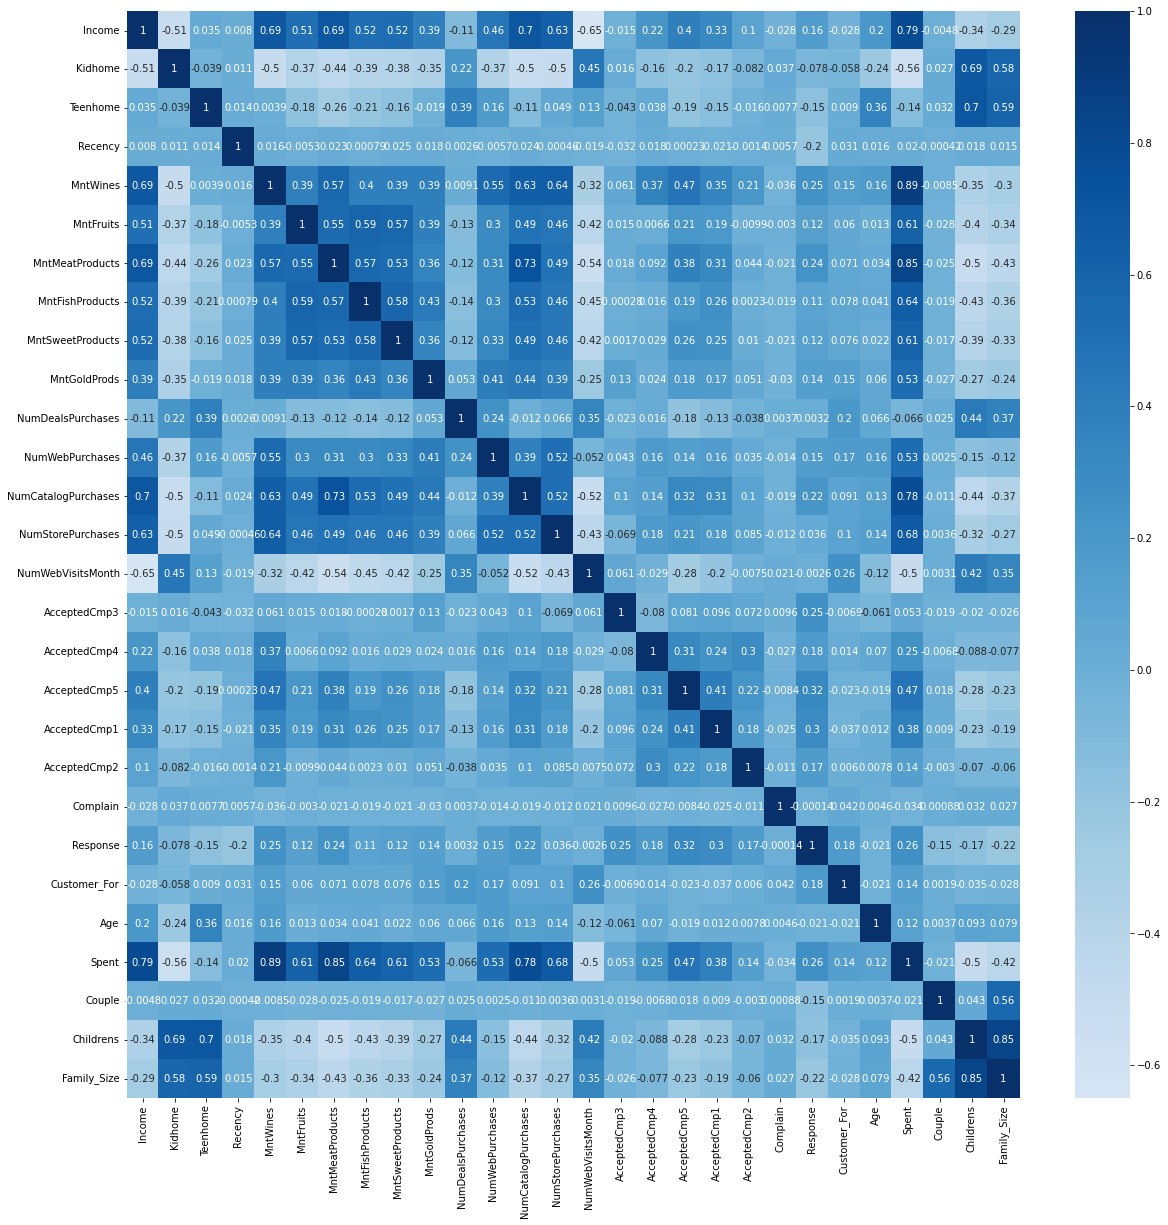

In [17]:
m_corr = df.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(m_corr, cmap="Blues", center=0, annot=True)

Observamos que los atributos que tengan que ver con el dinero como **Income**, **Spent** y los atributos del gasto en cada producto estan correlacionados. Además, otros atributos que se encuentran correlacionados entre sí son los atributos que tiene  que ver con la representación de las familias como **Childrens**, **Family_Size** o **Teenhome**.